<a href="https://colab.research.google.com/github/diegompin/mtsa/blob/feature%2Fv0.0.8/examples/MTSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MTSA - **M**ultiple **T**ime **S**eries **A**nalysis


### Installing MTSA module:

In [ ]:
!pip install mtsa

### Cloning MTSA repository:

*Obs: This step is necessary to access the example data.*

In [ ]:
!git clone https://github.com/diegompin/mtsa.git

### Setting data directory:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
path_input_1 = os.path.join(os.getcwd(),   "slider", "id_00")
path_input_2 = os.path.join(os.getcwd(),  "Data", "slider", "id_00")

In [3]:
import torch
import tensorflow as tf
gpuTorch = torch.cuda.is_available()
gpuTF = tf.test.is_gpu_available()
if gpuTorch:
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
gpus = tf.config.list_physical_devices('GPU')
print(gpus ,gpuTF)


assert len(gpus) < 0, "Not enough GPU hardware devices available"
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


gpus


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
NVIDIA GeForce RTX 3070 Ti Laptop GPU
[] False


AssertionError: Not enough GPU hardware devices available

In [4]:
import sys
sys.path.append("..")

### Reading Data Files:

In [5]:
from mtsa import files_train_test_split
#path_input_1 = '/data/MIMII/fan/id_00/'
X_train, X_test, y_train, y_test = files_train_test_split(path_input_1)
if(len(y_train) == 0): 
    X_train, X_test, y_train, y_test = files_train_test_split(path_input_2)
y_train

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### Preprocessing Mimii .wav files into MFCC arrays and generating chunks

In [6]:
from mtsa import Wav2Array
from mtsa import Array2Mfcc
import numpy as np
import pandas as pd
import torch as th
from sklearn.model_selection import train_test_split
import pickle as pkl



### Convert .wav files to MFCC


In [8]:
w2a = Wav2Array(16000)

wavArrayTrain  = w2a.transform(X_train)
wavArrayTest  = w2a.transform(X_test)


In [10]:
wavArrayTest.shape

(712, 160000)

In [15]:
array2mfcc_Train = Array2Mfcc(16000)
 
train_mfcc =  array2mfcc_Train.transform(wavArrayTrain)

array2mfccTest = Array2Mfcc(16000)

test_mfcc =  array2mfccTest.transform(wavArrayTest)


train_mfcc.shape, test_mfcc.shape



((712, 20, 313), (712, 20, 313))

In [24]:
train_mfcc

array([[[-4.90106567e+02, -4.55618347e+02, -4.48428741e+02, ...,
         -4.65633514e+02, -4.69448547e+02, -4.77055634e+02],
        [ 1.32247360e+02,  1.40794586e+02,  1.44545410e+02, ...,
          1.39753342e+02,  1.37583115e+02,  1.32106430e+02],
        [ 6.38315487e+00,  1.91787028e+00, -6.33089602e-01, ...,
         -6.75505829e+00, -8.33828545e+00, -8.06677628e+00],
        ...,
        [-1.95628750e+00, -2.27602482e+00,  1.48715198e+00, ...,
         -1.38971257e+00, -5.01460743e+00, -1.20281708e+00],
        [-9.60069084e+00, -2.98426366e+00, -4.06666613e+00, ...,
         -3.52169156e-01, -1.77696300e+00,  1.45258868e+00],
        [-2.33034015e+00, -9.39792395e-01,  3.88148129e-01, ...,
          3.79010677e+00,  8.48653838e-02,  4.62812662e+00]],

       [[-4.84633392e+02, -4.71696136e+02, -4.74537048e+02, ...,
         -4.81284821e+02, -4.85320892e+02, -4.76712524e+02],
        [ 1.17563065e+02,  1.28414505e+02,  1.31163544e+02, ...,
          1.36108490e+02,  1.33667480e

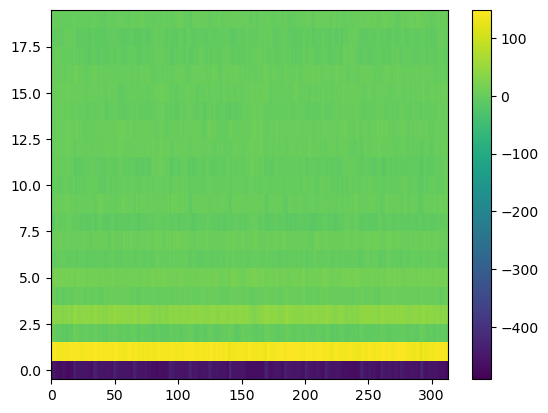

In [23]:
# plot the  mfcc

import matplotlib.pyplot as plt

plt.imshow(train_mfcc[0], interpolation="nearest", origin="lower", aspect="auto")
plt.colorbar()


In [25]:
train_chunks

array([], dtype=float64)